#### Model Selection

Having performed feature selection, now its time to investigate different models.  
I will test model behaviour with all the features and with the 15 best.

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pickle as pk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, matthews_corrcoef, confusion_matrix, ConfusionMatrixDisplay, make_scorer, recall_score
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import ComplementNB
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from imblearn.ensemble import RUSBoostClassifier
import time

In [4]:
with open("x_training.pkl" , "rb") as file:
    x_training = pk.load(file)
with open("y_training.pkl" , "rb") as file:
    y_training = pk.load(file)

#### 1. Dataset creation (all features and 15 best)

In [5]:
# dataset with 15 best features:

best_features=['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke',
       'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth']
x_training_select = x_training[best_features]
x_training_select.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth
49845,1.0,0.0,1.0,39.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,3.0,3.0
49936,1.0,1.0,1.0,47.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,4.0,0.0
49968,1.0,0.0,1.0,32.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,4.0,0.0
49978,1.0,1.0,1.0,30.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0
50016,0.0,0.0,1.0,43.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,5.0,4.0


In [6]:
# dataset with all features:

x_training.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
49845,1.0,0.0,1.0,39.0,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,3.0,3.0,0.0,1.0,0.0,8.0,6.0,7.0
49936,1.0,1.0,1.0,47.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,4.0,0.0,6.0,0.0,0.0,10.0,5.0,6.0
49968,1.0,0.0,1.0,32.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,1.0,4.0,0.0,4.0,0.0,0.0,9.0,3.0,3.0
49978,1.0,1.0,1.0,30.0,1.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,4.0,6.0
50016,0.0,0.0,1.0,43.0,1.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,5.0,4.0,4.0,1.0,0.0,3.0,3.0,5.0


#### 2. Initial cohort of models

I selected models that are likely to perform well even with high class imbalance as in this case.  
I will test a the models with initial settings (hyperparameters) that i think are appropriate, and I will tune them later.  
I excluded an SVM classifier because, considering the size of the dataset, it would take hours to fit

In [7]:
# the HistGradientBoostingClassifier from ImbalanceLearn needs a boolean mask for categorical features

boolean_mask_tot = [False if col == "BMI" or col == "MentHlth" or col == "PhysHlth" else True for col in x_training.columns]
boolean_mask_15 = [False if col == "BMI" or col == "MentHlth" else True for col in x_training_select.columns]

In [8]:
# initialize all models

#logistic regression as baseline
logistic_reg = Pipeline([
    ('scaler', StandardScaler()), 
    ('lgr', LogisticRegression(
        solver="lbfgs", 
        max_iter=500, 
        class_weight="balanced"
    ))
])

# Histogram based Gradient Boosting classifier from scikit-learn
hgbc_tot = HistGradientBoostingClassifier(
    random_state = 42,
    class_weight="balanced",
    max_iter=500,
    categorical_features=boolean_mask_tot
)

# 15 features version
hgbc_15 = HistGradientBoostingClassifier(
    random_state = 42,
    class_weight="balanced",
    max_iter=500,
    categorical_features=boolean_mask_15
)

# Balanced random forest
bal_rfc = BalancedRandomForestClassifier(
    n_estimators = 500,
    replacement=False,
    random_state=42,
    n_jobs=-1    
)

# The classifier is an ensemble of AdaBoost learners trained on different balanced bootstrap samples. 
# The balancing is achieved by random under-sampling.

eec = EasyEnsembleClassifier(
    n_estimators = 100,
    replacement=False,
    n_jobs=-1,
    random_state = 42    
)

# Gaussian Naive Bayes
g_bayes = GaussianNB()

#Naive Bayes better suited for imbalanced classes according to documentation
com_bayes = ComplementNB() 

#Random under-sampling integrated in the learning of AdaBoost.
#During learning, the problem of class balancing is alleviated by random under-sampling the sample at each iteration of the boosting algorithm.

base = DecisionTreeClassifier(max_depth=3) #this is needed otherwise default max depth is 1
rus_boost = RUSBoostClassifier(
    n_estimators=100,
    estimator = base
)

# create a dictionary to iterate on models
models = {"LogisticRegression" : logistic_reg , "HistGradientBoostingClassifier(tot)" : hgbc_tot, "HistGradientBoostingClassifier(15)" : hgbc_15 , "BalancedRandomForest": bal_rfc, "EasyEnsembleClassifier" : eec, "GaussianBayes" : g_bayes, "ComplementBayes" : com_bayes, "RUSBoostClassifier" : rus_boost}

I will now test pure performance (in terms of MCC) of the models with a 10 fold cross validation (maintaining class proportions)

#### 3. All features:

In [9]:
# set up data splits and cv strategy
results=[]
names=[]
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
mcc_score = make_scorer(matthews_corrcoef)

for name , model in models.items():
    if name == "HistGradientBoostingClassifier(15)":
        continue
    start = time.time()
    cv_results = cross_val_score(model, x_training, y_training, cv=cv, scoring=mcc_score)
    sep = 35 - len(name)
    end = time.time()
    print(f"{name}"+"_"*sep+f"   mean = {cv_results.mean():.4f}   std = {cv_results.std():.4f}   time = {((end-start)/60):.2f}")
    results.append(cv_results)
    names.append(name)

LogisticRegression_________________   mean = 0.2956   std = 0.0039   time = 0.07
HistGradientBoostingClassifier(tot)   mean = 0.2964   std = 0.0040   time = 0.31
BalancedRandomForest_______________   mean = 0.2675   std = 0.0053   time = 1.68
EasyEnsembleClassifier_____________   mean = 0.2981   std = 0.0049   time = 1.68
GaussianBayes______________________   mean = 0.2932   std = 0.0070   time = 0.01
ComplementBayes____________________   mean = 0.1731   std = 0.0089   time = 0.01
RUSBoostClassifier_________________   mean = 0.2596   std = 0.0283   time = 0.02


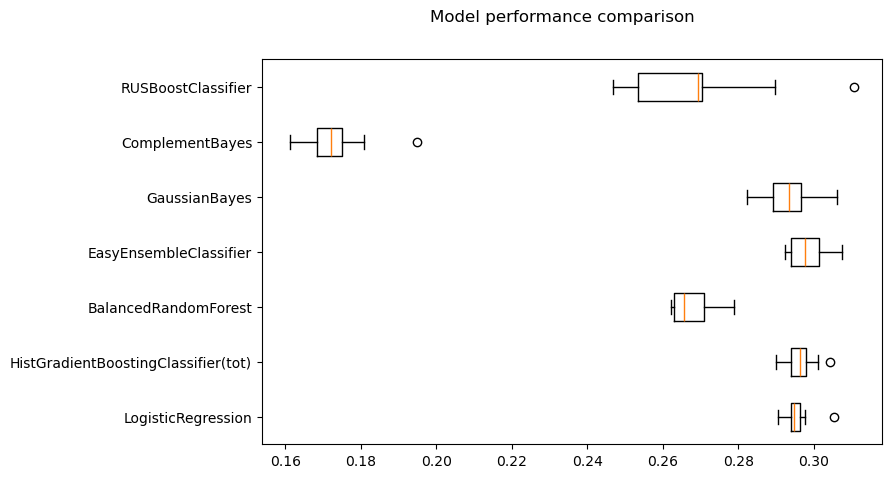

In [17]:
fig = plt.figure(figsize=(8, 5))
fig.suptitle("Model performance comparison")
ax = fig.add_subplot(111)
plt.boxplot(results , vert=False)
ax.set_yticklabels(names)
plt.show()

#### 15 best features

In [18]:
results=[]
names=[]

for name , model in models.items():
    if name == "HistGradientBoostingClassifier(tot)":
        continue
    start = time.time()
    cv_results = cross_val_score(model, x_training_select, y_training, cv=cv, scoring=mcc_score)
    sep = 35 - len(name)
    end = time.time()
    print(f"{name}"+"_"*sep+f"   mean = {cv_results.mean():.4f}   std = {cv_results.std():.4f}   time = {((end-start)/60):.2f}")
    results.append(cv_results)
    names.append(name)

LogisticRegression_________________   mean = 0.2881   std = 0.0032   time = 0.07
HistGradientBoostingClassifier(15)_   mean = 0.2865   std = 0.0051   time = 0.26
BalancedRandomForest_______________   mean = 0.2254   std = 0.0057   time = 1.64
EasyEnsembleClassifier_____________   mean = 0.2856   std = 0.0047   time = 1.47
GaussianBayes______________________   mean = 0.2891   std = 0.0066   time = 0.01
ComplementBayes____________________   mean = 0.1568   std = 0.0103   time = 0.01
RUSBoostClassifier_________________   mean = 0.2733   std = 0.0229   time = 0.02


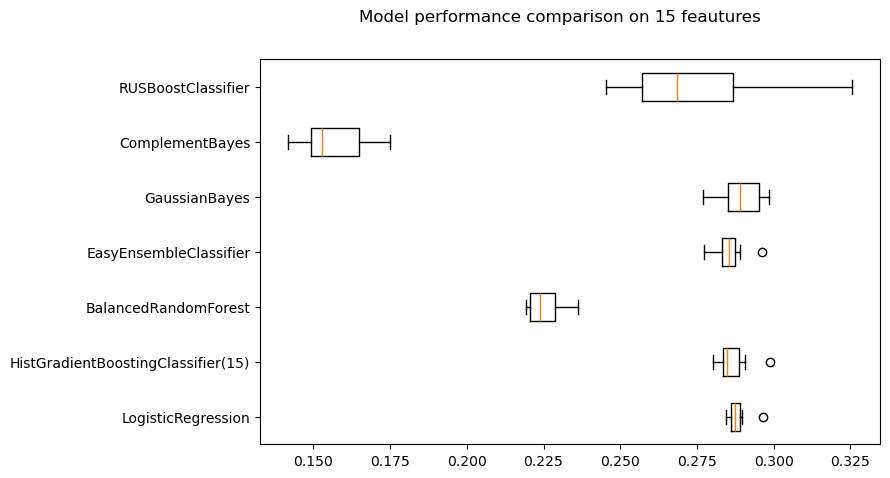

In [19]:
fig = plt.figure(figsize=(8,5))
fig.suptitle("Model performance comparison on 15 feautures")
ax = fig.add_subplot(111)
plt.boxplot(results , vert=False)
ax.set_yticklabels(names)
plt.show()

Now I will look at the classification report for each model, fitting on 80% of training set and testing on the remaining 20%

#### All features

In [12]:
# create train test splits

x_train_split, x_test_split, y_train_split, y_test_split = train_test_split(
    x_training, 
    y_training, 
    test_size=0.2, 
    stratify=y_training, 
    random_state=42
)

CLASSIFICATION REPORT LogisticRegression:

              precision    recall  f1-score   support

     Healthy       0.95      0.66      0.78     34193
    Pre-diab       0.03      0.30      0.06       741
        Diab       0.35      0.60      0.44      5655

    accuracy                           0.65     40589
   macro avg       0.44      0.52      0.43     40589
weighted avg       0.85      0.65      0.72     40589

MCC LogisticRegression:  0.2961417875161419


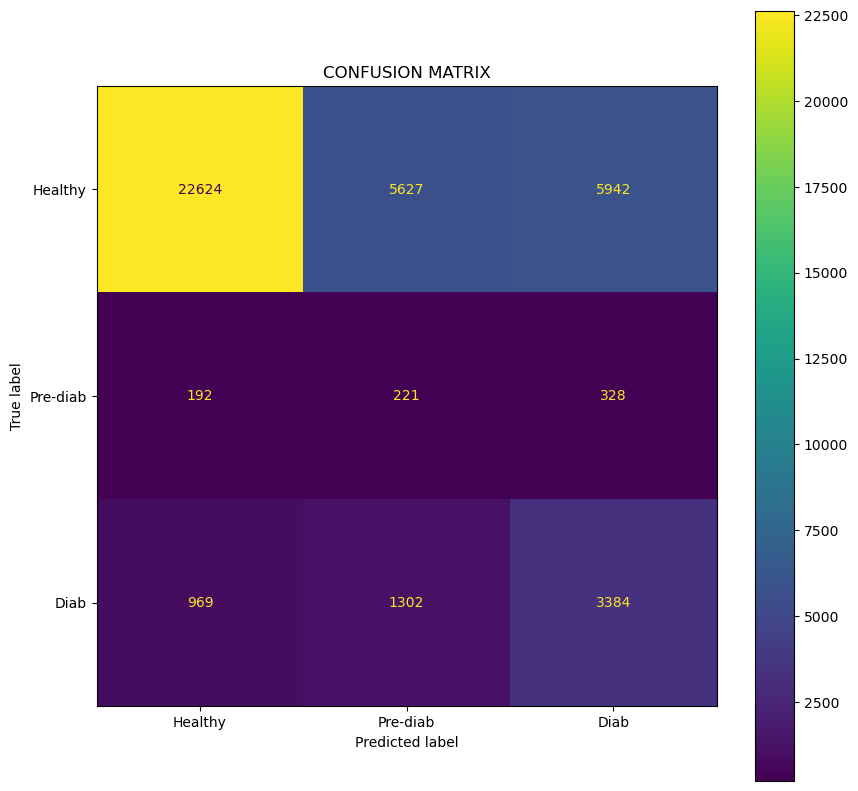

--------------------------------------------------------------------------------------------------------------------------


CLASSIFICATION REPORT HistGradientBoostingClassifier(tot):

              precision    recall  f1-score   support

     Healthy       0.95      0.64      0.76     34193
    Pre-diab       0.03      0.25      0.05       741
        Diab       0.34      0.64      0.45      5655

    accuracy                           0.63     40589
   macro avg       0.44      0.51      0.42     40589
weighted avg       0.85      0.63      0.71     40589

MCC HistGradientBoostingClassifier(tot):  0.29567568438343617


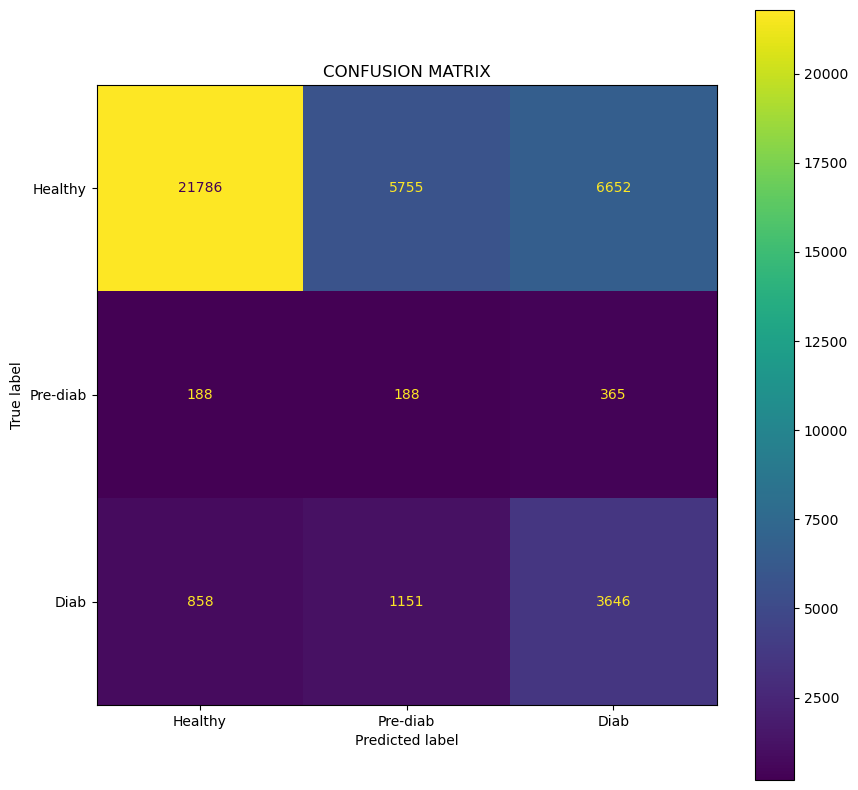

--------------------------------------------------------------------------------------------------------------------------


CLASSIFICATION REPORT BalancedRandomForest:

              precision    recall  f1-score   support

     Healthy       0.96      0.60      0.73     34193
    Pre-diab       0.03      0.37      0.05       741
        Diab       0.34      0.57      0.42      5655

    accuracy                           0.59     40589
   macro avg       0.44      0.51      0.40     40589
weighted avg       0.85      0.59      0.68     40589

MCC BalancedRandomForest:  0.2663155597376978


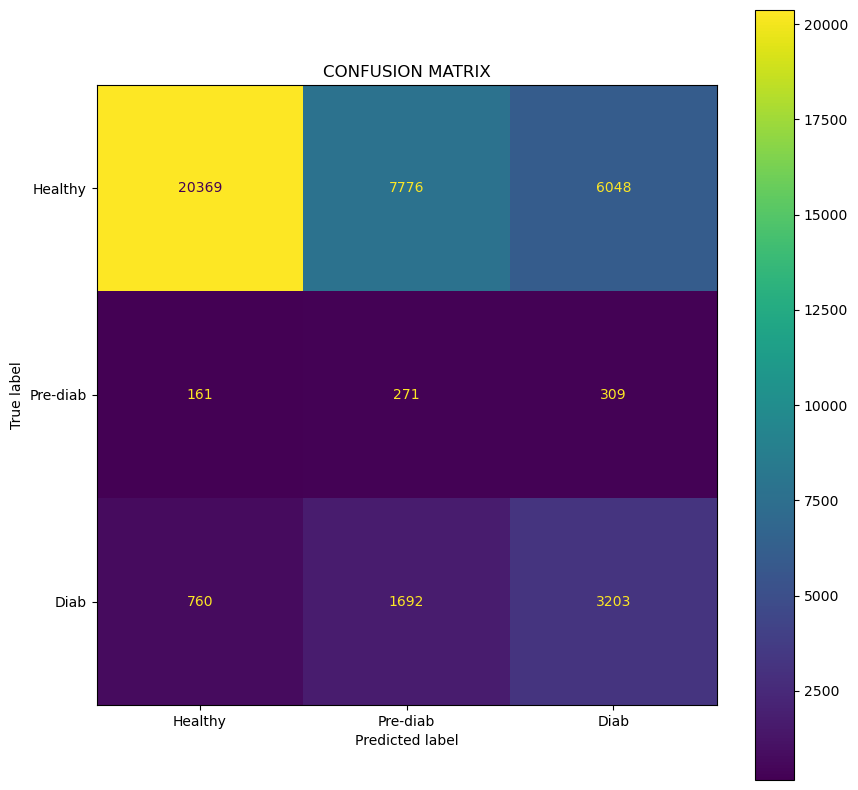

--------------------------------------------------------------------------------------------------------------------------


CLASSIFICATION REPORT EasyEnsembleClassifier:

              precision    recall  f1-score   support

     Healthy       0.95      0.66      0.78     34193
    Pre-diab       0.03      0.28      0.06       741
        Diab       0.35      0.62      0.45      5655

    accuracy                           0.64     40589
   macro avg       0.44      0.52      0.43     40589
weighted avg       0.85      0.64      0.72     40589

MCC EasyEnsembleClassifier:  0.2985792545917488


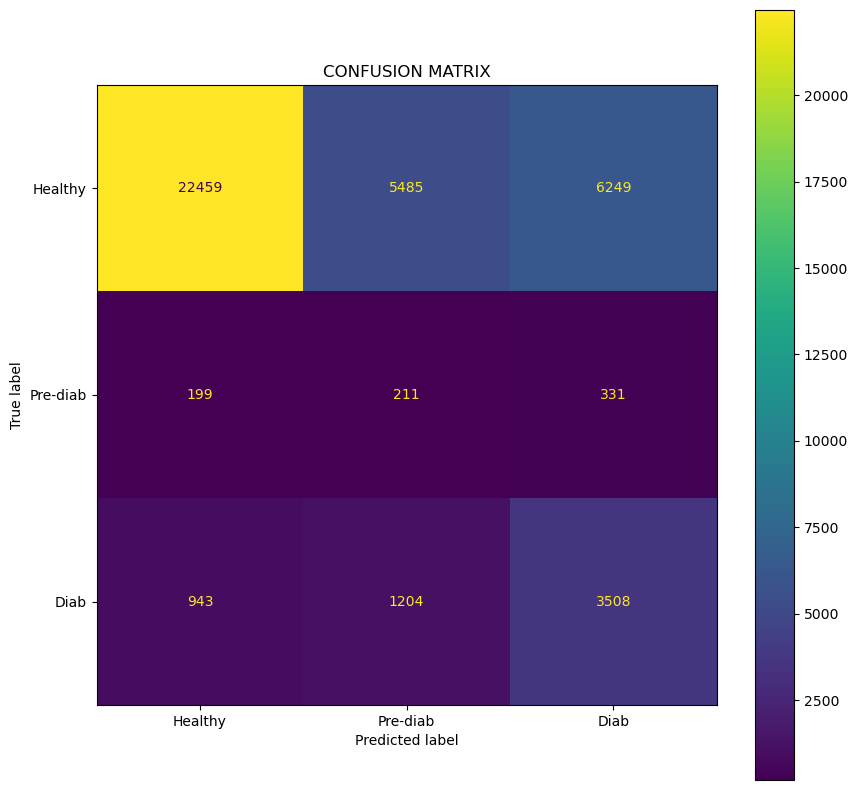

--------------------------------------------------------------------------------------------------------------------------


CLASSIFICATION REPORT GaussianBayes:

              precision    recall  f1-score   support

     Healthy       0.91      0.81      0.86     34193
    Pre-diab       0.03      0.01      0.02       741
        Diab       0.33      0.58      0.42      5655

    accuracy                           0.76     40589
   macro avg       0.42      0.47      0.43     40589
weighted avg       0.81      0.76      0.78     40589

MCC GaussianBayes:  0.3005954306894587


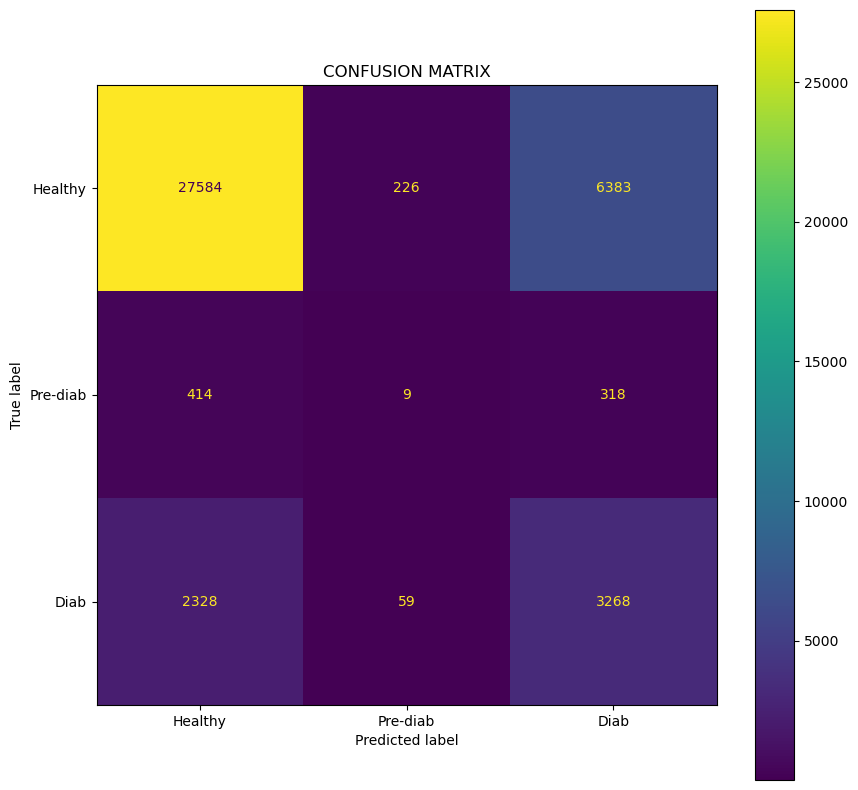

--------------------------------------------------------------------------------------------------------------------------


CLASSIFICATION REPORT ComplementBayes:

              precision    recall  f1-score   support

     Healthy       0.88      0.81      0.84     34193
    Pre-diab       0.00      0.00      0.00       741
        Diab       0.25      0.41      0.31      5655

    accuracy                           0.74     40589
   macro avg       0.38      0.41      0.38     40589
weighted avg       0.78      0.74      0.75     40589

MCC ComplementBayes:  0.1751746627728166


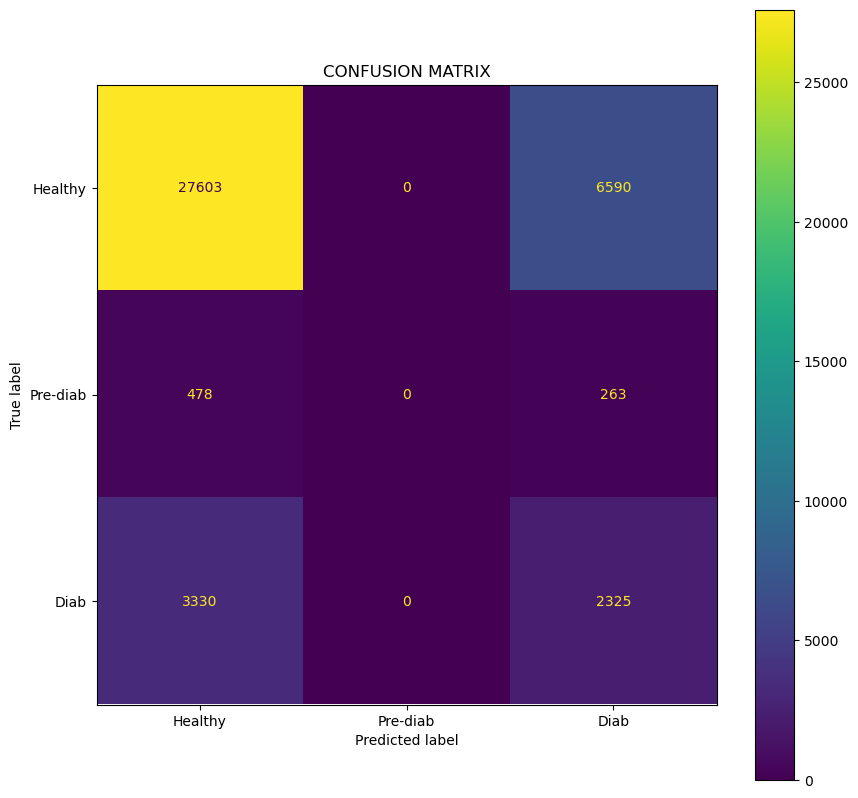

--------------------------------------------------------------------------------------------------------------------------


CLASSIFICATION REPORT RUSBoostClassifier:

              precision    recall  f1-score   support

     Healthy       0.95      0.55      0.70     34193
    Pre-diab       0.02      0.35      0.04       741
        Diab       0.33      0.56      0.42      5655

    accuracy                           0.55     40589
   macro avg       0.44      0.49      0.39     40589
weighted avg       0.85      0.55      0.65     40589

MCC RUSBoostClassifier:  0.24405021258721415


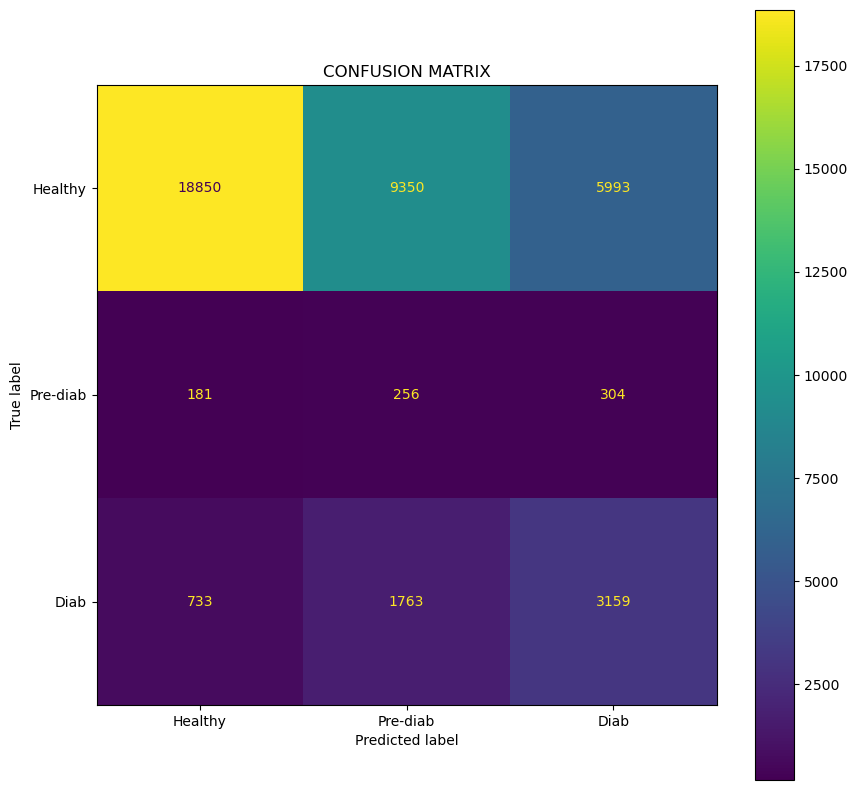

--------------------------------------------------------------------------------------------------------------------------




In [13]:
# iterate on models and show confusion matrix

for name , model in models.items():
    if name == "HistGradientBoostingClassifier(15)":
        continue

    model.fit(x_train_split , y_train_split)
    y_pred = model.predict(x_test_split)
    
    print(f"CLASSIFICATION REPORT {name}:\n")
    print(classification_report(y_test_split, y_pred, target_names=['Healthy', 'Pre-diab', 'Diab']))
    print(f"MCC {name}:  {matthews_corrcoef(y_test_split , y_pred)}")
    
    cm = confusion_matrix(y_test_split, y_pred, labels=[0, 1, 2])
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy', 'Pre-diab', 'Diab'])
    
    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(cmap='viridis', ax=ax, values_format='d') 
    plt.title("CONFUSION MATRIX")
    plt.show()
    
    print("--------------------------------------------------------------------------------------------------------------------------")
    print("\n")

#### 15  best Features

In [14]:
# create train test splits

x_train_split, x_test_split, y_train_split, y_test_split = train_test_split(
    x_training_select, 
    y_training, 
    test_size=0.2, 
    stratify=y_training, 
    random_state=42
)

CLASSIFICATION REPORT LogisticRegression (15 Features):

              precision    recall  f1-score   support

     Healthy       0.95      0.66      0.78     34193
    Pre-diab       0.03      0.27      0.05       741
        Diab       0.34      0.61      0.44      5655

    accuracy                           0.65     40589
   macro avg       0.44      0.51      0.42     40589
weighted avg       0.84      0.65      0.72     40589

MCC LogisticRegression:  0.29013463792558836


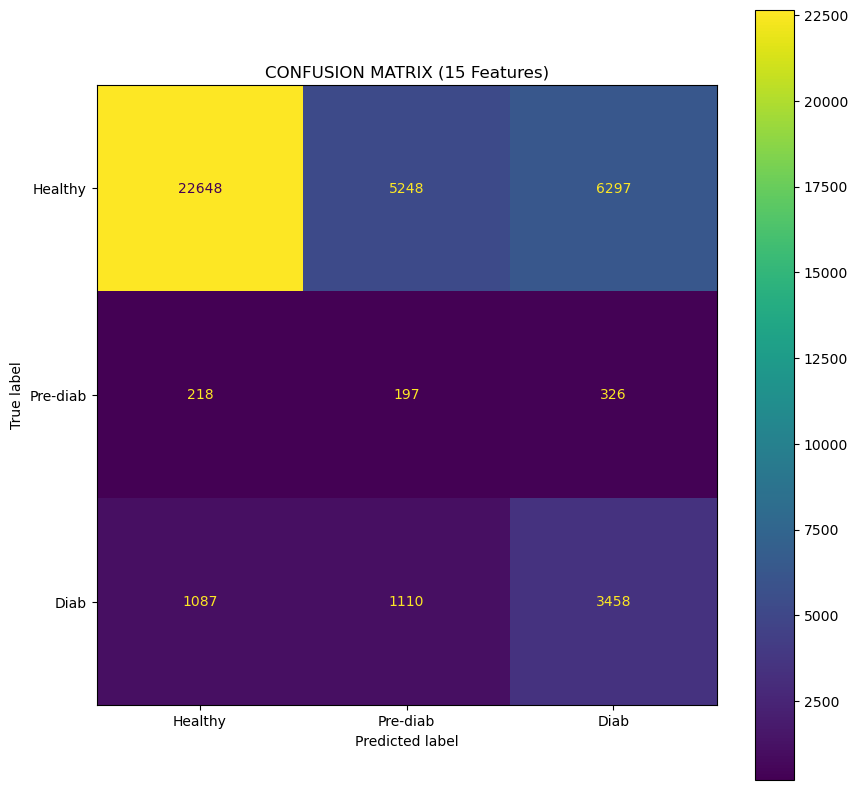

--------------------------------------------------------------------------------------------------------------------------


CLASSIFICATION REPORT HistGradientBoostingClassifier(15) (15 Features):

              precision    recall  f1-score   support

     Healthy       0.95      0.64      0.76     34193
    Pre-diab       0.03      0.24      0.05       741
        Diab       0.34      0.64      0.44      5655

    accuracy                           0.63     40589
   macro avg       0.44      0.51      0.42     40589
weighted avg       0.85      0.63      0.71     40589

MCC HistGradientBoostingClassifier(15):  0.28779399706433617


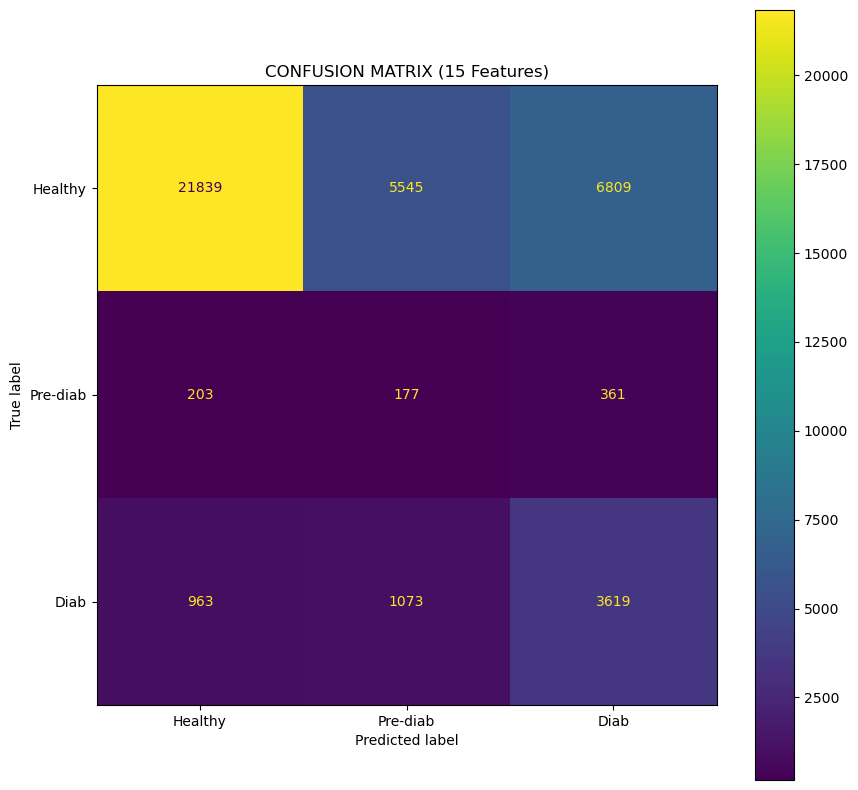

--------------------------------------------------------------------------------------------------------------------------


CLASSIFICATION REPORT BalancedRandomForest (15 Features):

              precision    recall  f1-score   support

     Healthy       0.95      0.55      0.70     34193
    Pre-diab       0.02      0.37      0.05       741
        Diab       0.31      0.51      0.39      5655

    accuracy                           0.54     40589
   macro avg       0.43      0.48      0.38     40589
weighted avg       0.84      0.54      0.64     40589

MCC BalancedRandomForest:  0.22720109867318053


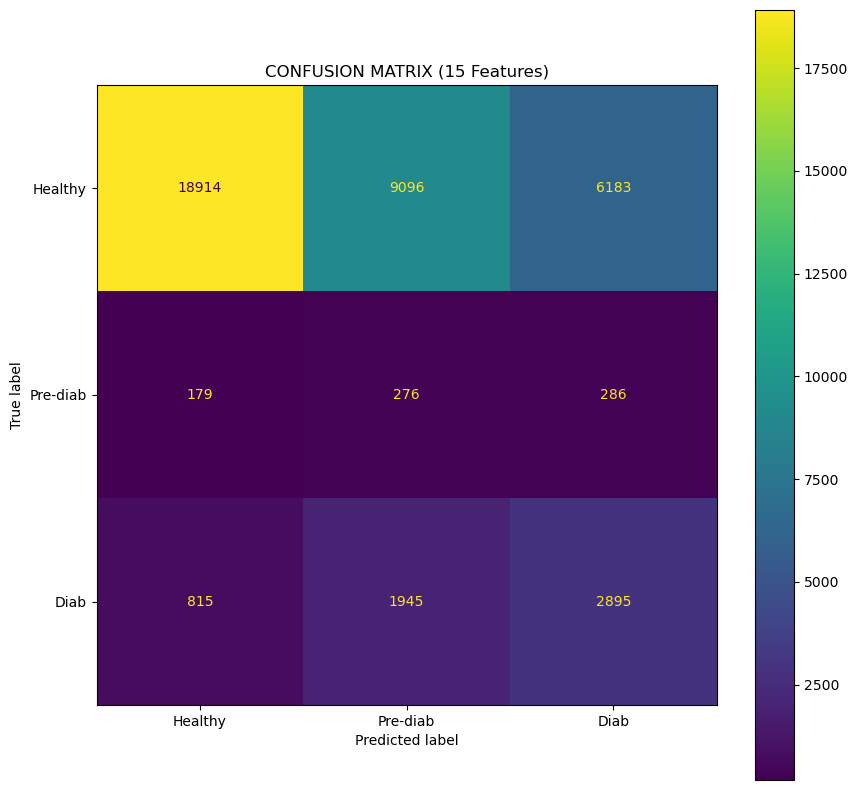

--------------------------------------------------------------------------------------------------------------------------


CLASSIFICATION REPORT EasyEnsembleClassifier (15 Features):

              precision    recall  f1-score   support

     Healthy       0.95      0.64      0.76     34193
    Pre-diab       0.03      0.28      0.05       741
        Diab       0.34      0.62      0.44      5655

    accuracy                           0.63     40589
   macro avg       0.44      0.51      0.42     40589
weighted avg       0.85      0.63      0.70     40589

MCC EasyEnsembleClassifier:  0.28447020569025766


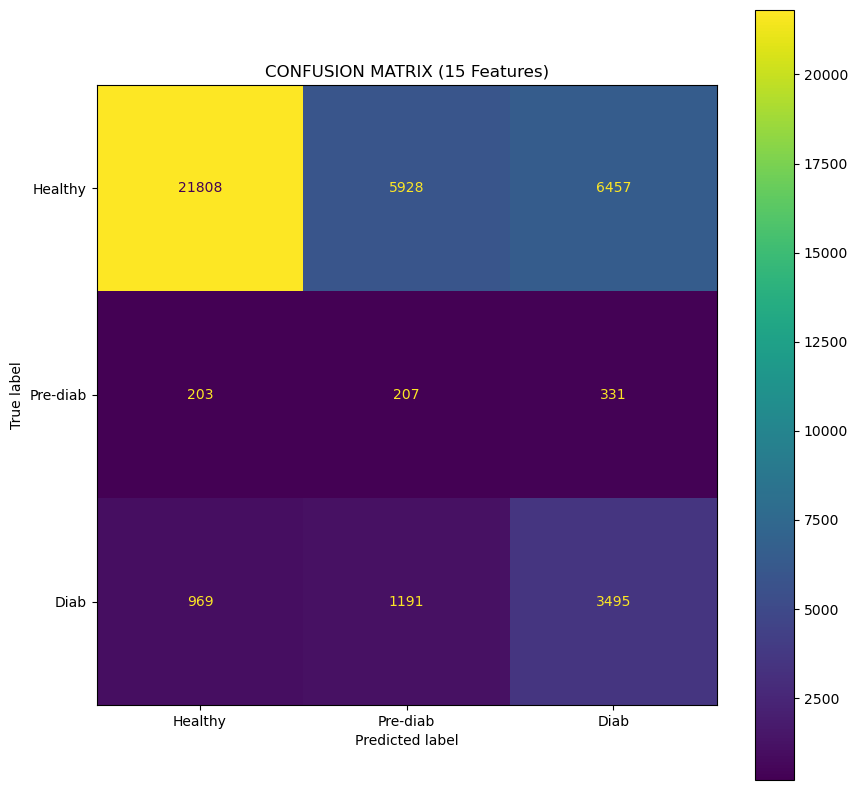

--------------------------------------------------------------------------------------------------------------------------


CLASSIFICATION REPORT GaussianBayes (15 Features):

              precision    recall  f1-score   support

     Healthy       0.90      0.83      0.86     34193
    Pre-diab       0.05      0.01      0.02       741
        Diab       0.33      0.54      0.41      5655

    accuracy                           0.77     40589
   macro avg       0.43      0.46      0.43     40589
weighted avg       0.81      0.77      0.79     40589

MCC GaussianBayes:  0.2958624012232243


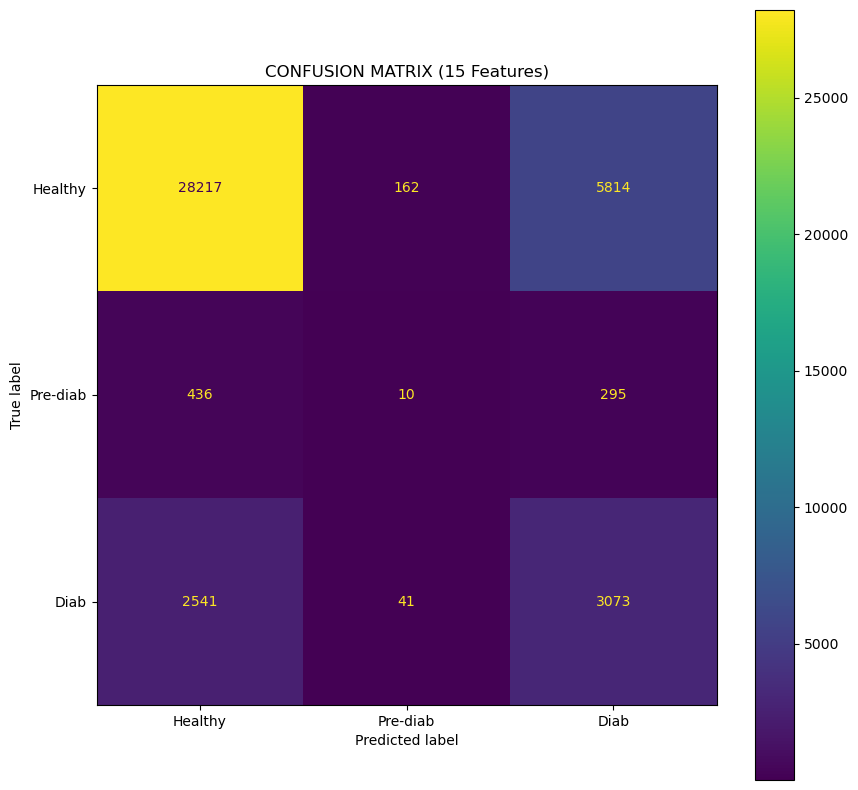

--------------------------------------------------------------------------------------------------------------------------


CLASSIFICATION REPORT ComplementBayes (15 Features):

              precision    recall  f1-score   support

     Healthy       0.88      0.79      0.83     34193
    Pre-diab       0.00      0.00      0.00       741
        Diab       0.24      0.41      0.30      5655

    accuracy                           0.72     40589
   macro avg       0.37      0.40      0.38     40589
weighted avg       0.77      0.72      0.74     40589

MCC ComplementBayes:  0.15656560710539905


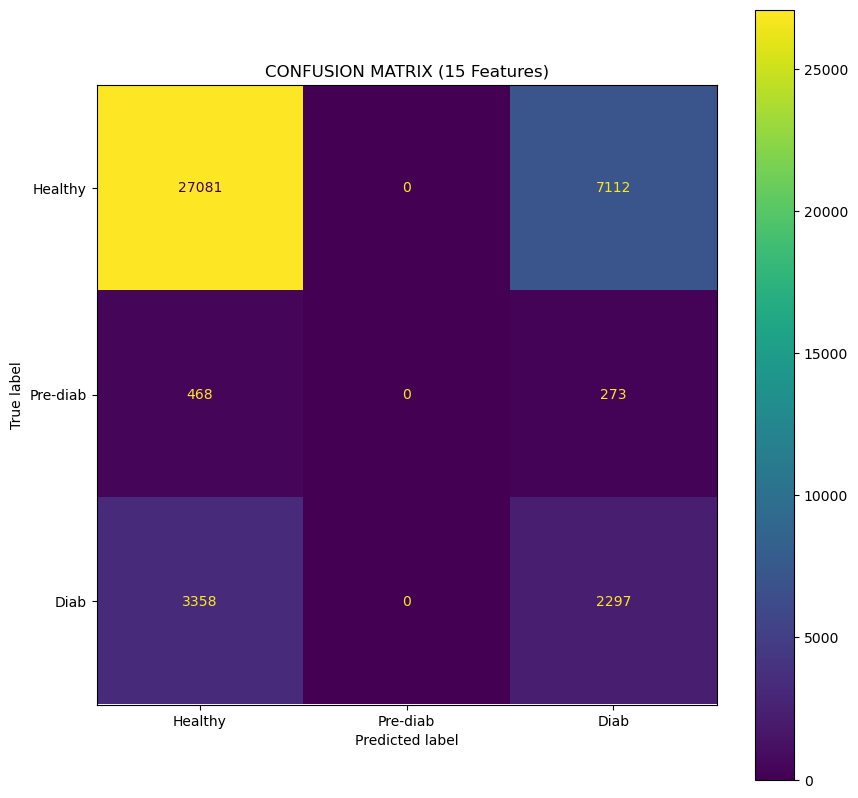

--------------------------------------------------------------------------------------------------------------------------


CLASSIFICATION REPORT RUSBoostClassifier (15 Features):

              precision    recall  f1-score   support

     Healthy       0.94      0.66      0.77     34193
    Pre-diab       0.03      0.11      0.05       741
        Diab       0.29      0.69      0.41      5655

    accuracy                           0.65     40589
   macro avg       0.42      0.49      0.41     40589
weighted avg       0.83      0.65      0.71     40589

MCC RUSBoostClassifier:  0.2833982766305156


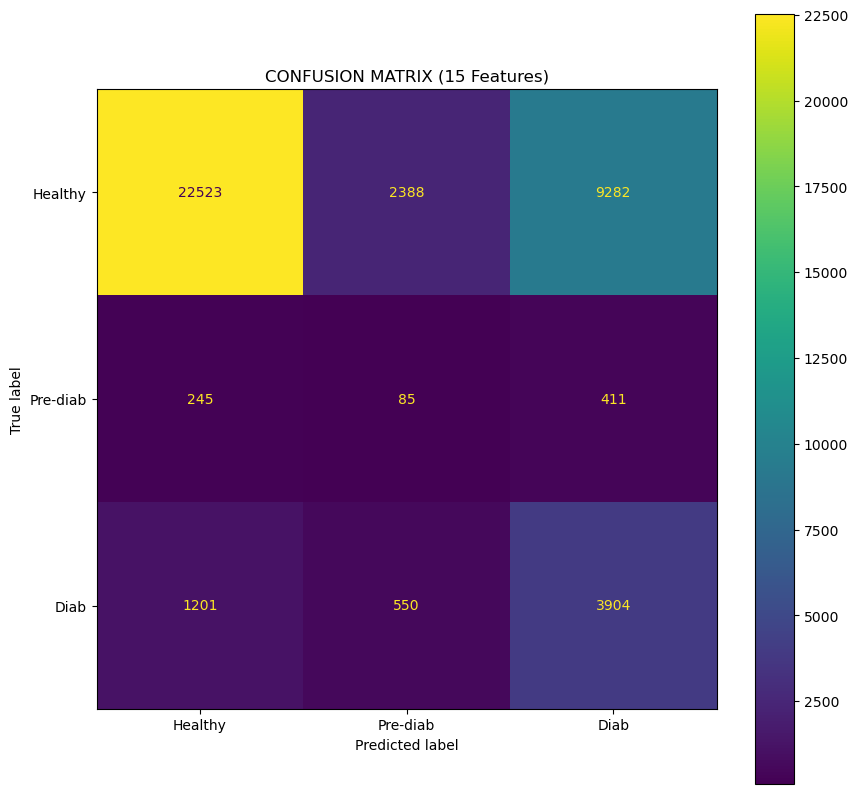

--------------------------------------------------------------------------------------------------------------------------




In [15]:
# iterate on models and show confusion matrix

for name , model in models.items():
    if name == "HistGradientBoostingClassifier(tot)":
        continue

    model.fit(x_train_split , y_train_split)
    y_pred = model.predict(x_test_split)
    
    print(f"CLASSIFICATION REPORT {name} (15 Features):\n")
    print(classification_report(y_test_split, y_pred, target_names=['Healthy', 'Pre-diab', 'Diab']))
    print(f"MCC {name}:  {matthews_corrcoef(y_test_split , y_pred)}")
    
    cm = confusion_matrix(y_test_split, y_pred, labels=[0, 1, 2])
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy', 'Pre-diab', 'Diab'])
    
    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(cmap='viridis', ax=ax, values_format='d') 
    plt.title("CONFUSION MATRIX (15 Features)")
    plt.show()
    
    print("--------------------------------------------------------------------------------------------------------------------------")
    print("\n")

#### 4. Results:

Apart from MCC, which shows the overall performance of the model, Recall is also a very important metric in this particular situation, since a probable use case for a model trained on this dataset is to select who is eligible for further medical tests to verify the presence of a pathological state (diabetes of pre-diabetes).  

MCC and Recall always got worse or at most equal when testing the model with the 15 features dataset, except for RUSBoostClassifier that showed an improved diabetic Recall (0.69 vs 0.56) but a lower prediabetic Recall (0.11 vs 0.35).  
I therefore conclude that there is no advantage in using a reduces set of features, also considering that all the features are derived from a questionnaire, and therefore are not expensive to produce.  

Naive Bayes models showed terrible Recall for prediabetics and diabetics. I will not develop them.    
Logistic regression performed surprisingly well in both MCC and Recall.  
Gradient Boosting models did not significantly outperform Balanced Random Forest model.  
There is no clear winner.  


I will now look at recall of prediabetes and diabetes class.  

#### 5. Recall variance

In [26]:
# define a recall score
scoring = {
    'recall_prediab': make_scorer(recall_score, average='micro', labels=[1]),
    'recall_diab':    make_scorer(recall_score, average='micro', labels=[2])
}

for name, model in models.items():
    if name == "HistGradientBoostingClassifier(15)":
        continue
        
    start = time.time()
    
    cv_recall = cross_validate(model, x_training, y_training, cv=cv, scoring=scoring)
    
    end = time.time()

    # Prediabetes
    rec1_mean = cv_recall['test_recall_prediab'].mean()
    rec1_std  = cv_recall['test_recall_prediab'].std()
    
    # Diabetes
    rec2_mean = cv_recall['test_recall_diab'].mean()
    rec2_std  = cv_recall['test_recall_diab'].std()

    sep = 35 - len(name)
    print(f"{name}"+"_"*sep+f"    mean recall pre = {rec1_mean:.4f}    std pre = {rec1_std:.4f}    time = {((end-start)/60):.2f}")
    print(f"{name}"+"_"*sep+f"    mean recall dia = {rec2_mean:.4f}    std dia = {rec2_std:.4f}    ")
    print("\n")

LogisticRegression_________________    mean recall pre = 0.3047    std pre = 0.0187    time = 0.08
LogisticRegression_________________    mean recall dia = 0.5933    std dia = 0.0088    


HistGradientBoostingClassifier(tot)    mean recall pre = 0.2867    std pre = 0.0261    time = 0.30
HistGradientBoostingClassifier(tot)    mean recall dia = 0.6359    std dia = 0.0121    


BalancedRandomForest_______________    mean recall pre = 0.3617    std pre = 0.0232    time = 1.65
BalancedRandomForest_______________    mean recall dia = 0.5666    std dia = 0.0103    


EasyEnsembleClassifier_____________    mean recall pre = 0.2678    std pre = 0.0166    time = 1.89
EasyEnsembleClassifier_____________    mean recall dia = 0.6185    std dia = 0.0073    


GaussianBayes______________________    mean recall pre = 0.0213    std pre = 0.0074    time = 0.01
GaussianBayes______________________    mean recall dia = 0.5679    std dia = 0.0084    


ComplementBayes____________________    mean recall pre 

#### 5. Results:  

It is clear from these results that all the classifiers in the current state are failing to recognize prediabetics.

Logistic regression showed decent recall (compared to the others) of both diabetics and prediabetics with little std.  
HistGradientBoostingClassifier showed good performance but with relatively high std.  
Balanced random forest showed good recall for prediabetics and low std.  
EasyEnsembleClassifier showed slightly worse performance than the HistGradientBoosting model but with lower std.
RUSBoostClassifier was outperformed by the EasyEnsembleClassifier in both recall and std.  
The Naive Bayes methods were completely outperformed by every other model.  

Again, there is no clear winner.  
I will no longer consider the Naive Bayes methods as well as the RUSBoostClassifier and I will try to improve the performance of the other models.


#### Hierarchical approach:
Considering that the models have difficulties in predicting prediabetics, I will try an Hierarchical approach:    

First classifier:    healthy vs unhealthy (prediabetic + diabetic)  
Second classifier:   healthy vs prediabetic vs diabetic

The first classifier should remove most of the "easy cases" so that the second classifier can more easly detect differences between prediabetics and diabetics